# Notebook for Monte-Carlo Simulation

In [106]:
## Import Various Packages 

%load_ext autoreload
%autoreload 2

%load_ext line_profiler
# Import files related to the model
from Simulation import simulate
import EGM
import tools
import DC_EGM
import Estimation as est

# Import General packages 
import numpy as np
from scipy import optimize
from model import Model
from matplotlib import pyplot as plt
import pickle
import seaborn as sns
import auxiliary_funcs as af
import time as time
import copy as copy
import pandas as pd 

import warnings
warnings.filterwarnings('ignore') #:)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [107]:
# Parameters used 
par2 = {'a_max':100,
        'Smax': 6,
        'sigma_taste': 0.3,
        'sigma': 0.5,
        'm_initial': 1,
        'phi_high': 5,
        'phi_low': 1,
        'theta_high':0.66,
        'theta_low':0.33,
        'lambda_max':0.797
        }

In [108]:
# Set up of the model
model = Model() # Load model
model.setup() # Set initial parameters 

# solution and simulation specs
model.par.Na = 200
model.par.Tmax = 45
model.par.Tsim = model.par.Tmax
model.par.Ntypes = 4
model.par.N = 10000
model.par.Ns = 10
# set parameters to those in par2
for key, val in par2.items():
    model.par.__setattr__(key, val)

model.par.easy_par=False # Not used

# Set grids
model.set_grids()

par = model.par
sol = model.sol
sim = model.sim

In [109]:
# Solve Model 
model.solve()
print("Model Solved")

Model Solved


# 1) Monte Carlo Experiment I 

In [77]:
run = True # Change to True to Run the Experiment

if run == False: 
    # Initialize 
    Results = {}  # Dictionary for results
    dist_true = [0.25,0.25,0.25,0.25] # True parameters 
    N = 50 # Number of MC iterations 

    for i in range(N): 

        par.dist = dist_true # Reset distribution to the true distribution

        est.reset_sim(sim,model) # Allocate simulation grids

        # Change Seed 
        seed_obj = np.random 
        seed_obj.seed(1667+i)
        par.random = seed_obj

        simulate(sim,sol,par) # Simulate 
        
        data = model.sim  # Save simulation results
 
        sec = time.time() # Start timing

        res,_ = est.estimate(est.obj,data,model,[0.2,0.8]) # Estimate from geuss

        time_it = time.time() - sec # Calculate Time

        # Dictionary with results for iteration i
        result = {  "p1" : res.x[0], 
                    "p2" : res.x[1], 
                    "fun" : res.fun, 
                    "Succes" : res.success,
                    "Time" : time_it }
        
        Results[f"result_{i}"] = result # Save results 

In [21]:
results.std()

p1         0.026864
p2         0.026138
fun        0.596626
Succes     0.000000
Time      59.540754
dtype: float64

# 2) Monte Carlo Experiment II 

## 2.1) Monte Carlo  

In [79]:
run = False # Change to True to run

sol_true = copy.deepcopy(sol) # Save Actual Solution

if run == True: 
    # Initialize
    Results = {} # Dictionary for results
    
    # True parameters 
    dist_true = [0.25,0.25,0.25,0.25] 
    phi_high_true = 5

    N = 50 # Number of MC iterations 

    for i in range(N): 

        par.dist = dist_true # Set true distribution

        est.reset_sim(sim,model) # Allocation Simulation grids

        # Set Seed
        seed_obj = np.random
        seed_obj.seed(1687+i)
        par.random = seed_obj 

        setattr(model.par, "phi_high", phi_high_true) # Set true transfers 
        simulate(sim,sol_true,par) # Simulate
        
        data = model.sim # Save simulation

        sec = time.time() # Starting timing

        res = est.estimate_transfer(data,model,[0.2,0.8,3]) # Estimate 

        time_it = time.time() - sec #Calculate time

        # Dictionary for results of iteration i
        result = {  "p1" : res.x[0], 
                    "p2" : res.x[1],
                    "Phi_high" : res.x[2], 
                    "fun" : res.fun, 
                    "Succes" : res.success,
                    "Time" : time_it }
        
        Results[f"result_{i}"] = result # Save results

## 2.1) Play around with the results from Experiment II 

In [88]:
# Export experiment II to Pickle
'''
obj_result = Results 
file_result = open('MC.obj2','wb')
pickle.dump(obj_result,file_result,protocol=pickle.HIGHEST_PROTOCOL)
'''


"\nobj_result = Results \nfile_result = open('MC.obj2','wb')\npickle.dump(obj_result,file_result,protocol=pickle.HIGHEST_PROTOCOL)\n"

In [96]:
# Open results 
file_open = open('MC.obj2','rb')
saved_result = pickle.load(file_open)

In [97]:
# Change to dataframe 
Data_2 = pd.DataFrame(saved_result).T

In [98]:
Data_2.mean() # Find mean

p1            0.492586
p2            0.506192
Phi_high      5.002631
fun           3.384104
Succes        1.000000
Time        940.810290
dtype: float64

In [95]:
Data_2.std() # Find Standard Deviation

p1            0.078224
p2            0.023762
Phi_high      0.471917
fun          12.921332
Succes        0.000000
Time        117.555208
dtype: float64

In [28]:
# Unpack results 
phi_highs = np.empty(50)
p1s = np.empty(50)
p2s = np.empty(50)

for i in range(50): 
    phi_highs[i] = saved_result[f'result_{i}']["Phi_high"]
    p1s[i] = saved_result[f'result_{i}']["p1"]
    p2s[i] = saved_result[f'result_{i}']["p2"]

## 2.3) Make a scatter plot over the estimates of phi high and p1 

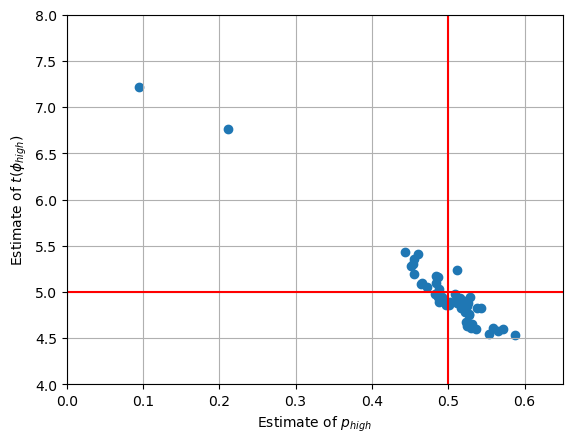

In [100]:
# Make scatter plot that shows the correlation 
fig,ax = plt.subplots(1,1)
ax.scatter(Data_2.p1,Data_2.Phi_high)

ax.set_ylabel("Estimate of $t(\phi_{high})$")
ax.set_xlabel("Estimate of $p_{high}$")
ax.grid()
ax.set_ylim([4,8])
ax.set_xlim([0,0.65])

ax.vlines(0.5,0,10,color="red")
ax.hlines(5,0,10,color="red")

fig.savefig(r"figs\scatter_phi_p_2.png")

In [101]:
# Inspect Outliers 
I = Data_2.fun>6
Data_2[I]

,p1,p2,Phi_high,fun,Succes,Time
result_24,0.211744,0.494812,6.759836,51.70163,True,792.346431
result_28,0.09437,0.434419,7.22307,77.656059,True,643.925917


# 3) Plot Criterion Functions 

## 3.1) Criterion Function for Experiment I 

In [138]:
# Set up of the model
model = Model() # Load model
model.setup() # Set initial parameters 

# solution and simulation specs
model.par.Na = 200
model.par.Tmax = 45
model.par.Tsim = model.par.Tmax
model.par.Ntypes = 4
model.par.N = 10000
model.par.Ns = 10
# set parameters to those in par2
for key, val in par2.items():
    model.par.__setattr__(key, val)

model.par.easy_par=False # Not used

# Set grids
model.set_grids()

par = model.par
sol = model.sol
sim = model.sim

# Simulate and find income shares 
model.solve()
simulate(sim,sol,par)
data = copy.deepcopy(sim)
share_Rich = np.sum((data_true.type == 0) + (data_true.type == 2)) / len(data_true.type) 
share_Poor = 1-share_Rich


In [139]:
run = True # Change to True to run

if run:
    N = 10 # Points in each dimension

    # Set values 
    p1s = np.linspace(1e-8, 1-1e-8, N)
    p2s = np.linspace(1e-8, 1-1e-8, N)

    criterion = np.zeros((N,N)) # Grid to save values 

    for i1,p1 in enumerate(p1s): # Find criterion value for each point in p1s x p2s 
        for i2,p2 in enumerate(p2s):
            c = est.obj([p1,p2], data, model, [share_Rich, share_Poor], "I")
            criterion[i1,i2] = c

    to_file = (p1s, p2s, criterion) # Make ready to save 

    with open('criterion_plot_10000','wb') as file: # Save File 
        pickle.dump(to_file, file)

626.9866363286424
489.5775148989072
395.23515612140125
324.5333715033224
291.9000491954629
289.03631542295716
305.6844263913851
362.9260763029929
452.86580452795124
579.66064382397
518.4994026127376
384.70850192384484
281.02837194320136
214.9200367679609
180.79585713966628
172.3576250220659
193.43711472999587
250.8142036747231
341.59489522085835
465.2426315911593
436.6191942053074
294.400137722598
196.59182505065314
130.72419319217443
92.12690406476425
85.86677361711007
109.17870067816723
168.30463839851535
257.17833735764646
383.75338158423506
382.31116602708113
244.90540866441924
147.89727281202482
75.52127847959797
36.98092443341068
29.156357983506304
53.98855354409541
110.26632391124201
199.9902575208216
321.31594552870456
358.7381894081746
225.01326190972324
122.89151083104959
50.01779879243384
10.01421918432412
3.5373931444904243
28.72407296870209
86.03235143770743
174.10571084984255
304.1500596007
365.0761440442057
227.6352950423193
126.06417877450207
51.694756013199196
13.82531

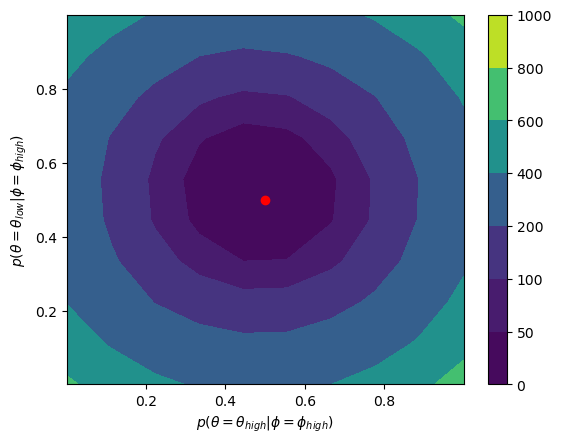

In [141]:
# Plot the criterion function using the values from above
%matplotlib inline

with open('criterion_plot_10000', 'rb') as file:
    p1s, p2s, criterion = pickle.load(file)

p1_mesh, p2_mesh = np.meshgrid(p1s, p2s,  indexing='ij')

fig = plt.figure()
ax = fig.add_subplot()
contour = ax.contourf(p1_mesh, p2_mesh, criterion, cmap='viridis', levels = [0,50, 100, 200, 400, 600, 800, 1000])
ax.set_xlabel(r'$p(\theta = \theta_{high} | \phi = \phi_{high})$')
ax.set_ylabel(r'$p(\theta = \theta_{low} | \phi = \phi_{high})$')
ax.scatter(0.5, 0.5, color='red')

cbar = fig.colorbar(contour)

fig.savefig('figs/criterion_p1p2.png')

## 3.2) Criterion functions for Experiment II 

In [168]:
model_easy = Model()
model_easy.setup()

# solution and simulation specs
model_easy.par.Na = 200
model_easy.par.Tmax = 45
model_easy.par.Tsim = model.par.Tmax
model_easy.par.Ntypes = 4
model_easy.par.N = 10000

# set parameters
for key, val in par2.items():
    model_easy.par.__setattr__(key, val)

model_easy.par.easy_par = False
model_easy.set_grids()

print('Setup done')

model_easy.solve()
print('Model solved')

simulate(model_easy.sim, model_easy.sol, model_easy.par)
print('Model simulated')

Setup done
Model solved
Model simulated


In [169]:
data_easy = copy.deepcopy(model_easy.sim)

In [170]:
# Criterion function, fix p2=0.5
# tranfsers and p1
run = True

if run:
    p2 = 0.5
    N = 10
    p1_grid = np.linspace(1e-8, 1-1e-8, N)
    phi_grid = np.linspace(2, 8, N)
    p1_mesh, phi_mesh = np.meshgrid(p1_grid, phi_grid, indexing='ij')

    cri1_mesh = np.zeros((N,N)) + np.nan

    for i1,p1 in enumerate(p1_grid):
        for ip,phi in enumerate(phi_grid):
            c = est.obj_transfer([p1,p2, phi], data_easy, model_easy, [share_Rich, share_Poor], "I")
            cri1_mesh[i1,ip] = c

    to_file = (p1_grid, phi_grid, cri1_mesh)

    with open('criterion_plot_p1phi','wb') as file:
        pickle.dump(to_file, file)

1394.2228512416546
1011.0234922308422
712.3789771993613
492.17738577475535
335.15361396993296
239.21428993475504
170.59824095747499
131.46754534165626
108.8048375942043
100.45578090166673
1041.8909251394898
723.782657583593
490.00663650706883
321.60567390131956
203.6411940489979
136.55991949589006
91.83825351511598
69.14802236219505
61.37705500939938
63.888125480237875
740.8994806588894
489.6033378037226
310.3905041784318
184.61515547739626
102.99713839658831
60.53390109814896
36.10399945260169
27.924778272127636
32.57884661050581
45.42617189742616
500.4637900947338
311.25266360842306
179.76978983039743
92.2828827166263
40.60776771560986
17.025256836223097
9.554334003645732
13.799341193300517
28.162759634025942
48.443079166548486
308.06372127947697
171.9545632850302
84.5012175160245
31.991154179652547
6.724995344039419
1.1993144047660793
8.222128409508588
23.89713476030599
47.79328140030424
75.26265738700452
172.05957517772347
80.79188234350434
30.983138730070092
7.785397738096117
3.96

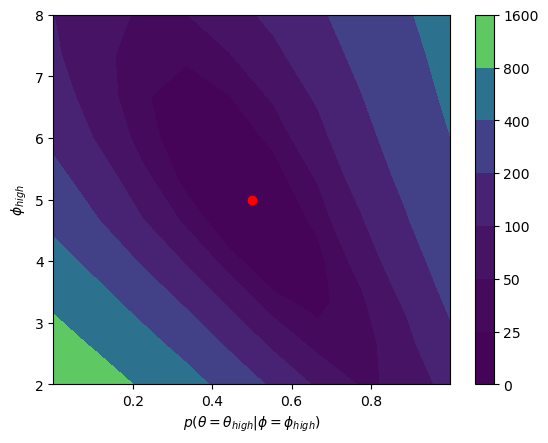

In [172]:
%matplotlib inline

with open('criterion_plot_p1phi', 'rb') as file:
    p1s, phi_grid, cri1_mesh = pickle.load(file)

p1_mesh, phi_mesh = np.meshgrid(p1s, phi_grid, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
contour = ax.contourf(p1_mesh, phi_mesh, cri1_mesh, levels=[0, 25, 50, 100, 200, 400, 800, 1600])
ax.set_xlabel(r'$p(\theta = \theta_{high} | \phi = \phi_{high})$')
ax.set_ylabel('$\phi_{high}$')

cmap = fig.colorbar(contour)

ax.scatter(0.5, 5, label='True value', color='red')

fig.savefig('figs/criterion_p1phi.png')

In [158]:
# Criterion function, fix p1=0.5
# transfers and p2

run = True

if run:
    p1 = 0.5
    N = 10
    p2_grid = np.linspace(1e-8, 1-1e-8, N)
    phi_grid = np.linspace(2, 8, N)
    p2_mesh, phi_mesh = np.meshgrid(p1_grid, phi_grid, indexing='ij')

    cri2_mesh = np.zeros((N,N)) + np.nan

    for i2,p2 in enumerate(p1_grid):
        for ip,phi in enumerate(phi_grid):
            c = est.obj_transfer([p1,p2, phi], data, model, [share_Rich, share_Poor], "I")
            cri2_mesh[i2,ip] = c

    to_file = (p2_grid, phi_grid, cri2_mesh)

    with open('criterion_plot_p2phi','wb') as file:
        pickle.dump(to_file, file)

585.6335610498938
477.2831065287549
409.1402745999691
371.86094642147685
358.571158927687
361.2359280148345
375.54066813793133
396.4584664637188
423.67473031987765
453.3387229491277
451.39082750768637
341.7780497617705
273.7847549937176
237.0611867622649
223.64209589557385
226.37131758997668
240.55872829514212
261.58563237714634
288.80353068438785
317.9842918310484
349.7660558282987
240.51865833402667
172.34996733568767
136.16011044644245
122.8631799376645
125.65702508139688
139.2777133869165
160.18944000893254
187.329430089229
216.7003712652926
278.9173408681454
167.93684530004936
99.18652418294096
61.930194060830146
48.36722228022566
50.812860531562286
63.963893937780696
84.440227908021
110.84574895203622
139.30400330681977
240.550111815717
128.2245279997269
59.61465292826891
22.284536448214126
8.948565479125007
11.530684164268884
25.07543650939496
45.181274715303815
72.6816344832211
102.35565896896543
234.134327005501
122.5109314616436
54.020152252895464
16.610123937140994
2.5239991

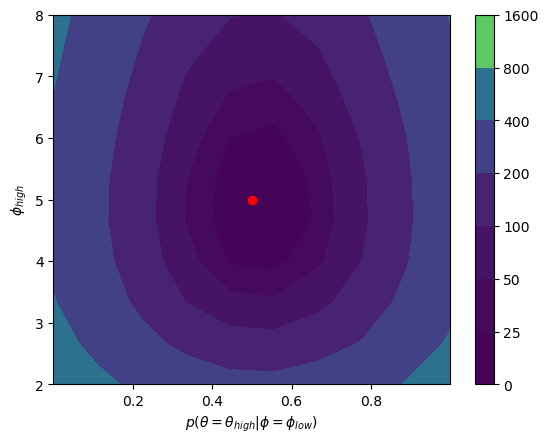

In [161]:
%matplotlib inline

with open('criterion_plot_p2phi', 'rb') as file:
    p2s, phi_grid, cri2_mesh = pickle.load(file)

p2_mesh, phi_mesh = np.meshgrid(p2s, phi_grid, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot()
contour = ax.contourf(p2_mesh, phi_mesh, cri2_mesh, cmap='viridis', levels=[0, 25, 50, 100, 200, 400, 800, 1600])
ax.set_xlabel(r'$p(\theta = \theta_{high} | \phi = \phi_{low})$')
ax.set_ylabel('$\phi_{high}$')

cmap = fig.colorbar(contour)

ax.scatter(0.5, 5, color='red')

fig.savefig('figs/criterion_p2phi.png')